# Environment

In [1]:
import os
import numpy as np

# Dataset

In [2]:
DATASET_ROOT = './datasets/VPRC2023'
FEAT_TYPE = 'resnet18_baseline'
FEAT_OUTPUT_FOLDER = f"{DATASET_ROOT}_{FEAT_TYPE}"

### Load

In [3]:
X_train, y_train = [], []
X_test, y_test = [], []
train_folder = os.path.join(FEAT_OUTPUT_FOLDER, 'train')
test_folder = os.path.join(FEAT_OUTPUT_FOLDER, 'test')

class_map = {}  # maps product id to class index
for f in sorted(os.listdir(train_folder)):
    path = os.path.join(train_folder, f)
    feat = np.load(path)
    feat = feat / np.linalg.norm(feat)  # normalize
    X_train.append(feat[:, np.newaxis])

    label = int(f[0:4])
    if label not in class_map:
        class_map[label] = len(class_map)
    y_train.append(class_map[label])
for f in sorted(os.listdir(test_folder)):
    path = os.path.join(test_folder, f)
    feat = np.load(path)
    feat = feat / np.linalg.norm(feat)  # normalize
    X_test.append(feat[:, np.newaxis])

    label = int(f[0:4])
    if label not in class_map:
        class_map[label] = len(class_map)
    y_test.append(class_map[label])
X_train = np.concatenate(X_train, axis=1)
y_train = np.array(y_train)
X_test = np.concatenate(X_test, axis=1)
y_test = np.array(y_test)

# Algorithm

### Solve and Predict

In [4]:
from sklearn.linear_model import Lasso
from tqdm import tqdm

k = len(np.unique(y_train))

y_pred = []
scis = []
for i in tqdm(range(X_test.shape[1])):
    clf = Lasso(alpha=1e-4)
    clf.fit(X_train, X_test[:, i])
    w = clf.coef_


    delta_ws = []
    for j in range(k):
        delta_w = np.zeros_like(w)
        delta_w[y_train == (j + np.min(y_train))] = w[y_train == (j + np.min(y_train))]
        delta_ws.append(delta_w)
    delta_ws = np.array(delta_ws)

    residuals = []
    for j in range(k):
        residuals.append(np.linalg.norm(X_test[:, i] - X_train @ delta_ws[j]))
    residuals = np.array(residuals)

    sci = (k * np.max(np.linalg.norm(delta_ws, ord=1, axis=1)) / np.linalg.norm(w, ord=1) - 1) / (k - 1)
    scis.append(sci)

    if sci >= 0.0:
        y_pred.append(np.argmin(residuals) + np.min(y_train))
    else: # reject
        y_pred.append(-1)

print(f"Precision: {np.mean(y_test == y_pred):.2f}")


100%|██████████| 1935/1935 [00:58<00:00, 32.89it/s]

Precision: 0.08


# Visualize

### Coefficients

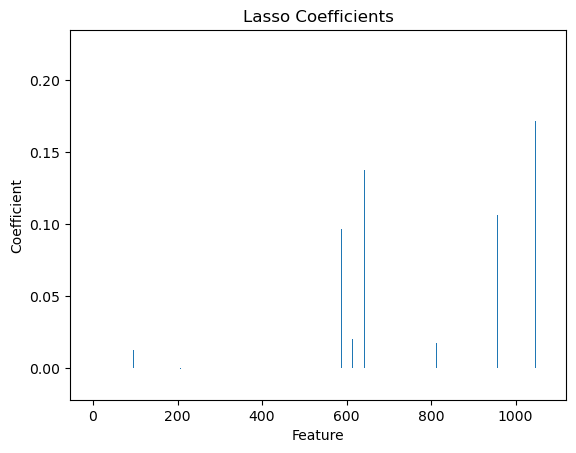

In [5]:
import matplotlib.pyplot as plt

plt.bar(range(len(w)), w)
plt.title("Lasso Coefficients")
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.show()

### Residuals

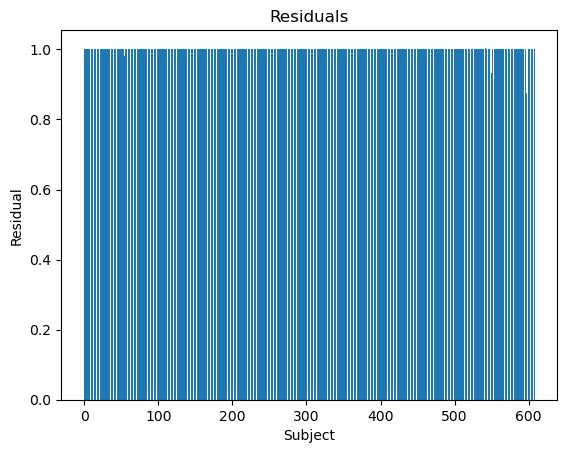

In [6]:
plt.bar(range(len(residuals)), residuals)
plt.title("Residuals")
plt.xlabel("Subject")
plt.ylabel("Residual")
plt.show()

In [7]:
np.mean(scis)

0.2154842865573186